Given a PSRCHIVE archive remove the RFI based off of a median value threshold.

Jacob Cardinal Tremblay

In [1]:
#Import Modules
import psrchive
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.cluster.vq import kmeans, vq
import scipy.stats as stats
from matplotlib import colors
from matplotlib.gridspec import GridSpec

In [2]:
def Read_File(file_path, dedisperse = True):
    File = psrchive.Archive_load(file_path)
    File.tscrunch()
    if dedisperse == True:
        File.dedisperse()
    File.pscrunch()
    File.remove_baseline()
    dm = File.get_dispersion_measure()
    center_freq = File.get_centre_frequency()
    integration = File.get_first_Integration()
    period = integration.get_folding_period()
    File_Data = File.get_data()
    pulse = File_Data[0,0,:] #Select usable part of data
    
    #Get a list of the frequencies
    freq_mhz_table = File.get_frequency_table()
    freq_mhz = freq_mhz_table[0]
    
    
    return(pulse, freq_mhz, dm, center_freq, period)

In [3]:
def dedisperse(data, dm, f_ref, freqs, time_res):
    """
    Function created in part by ChatGPT
    De-disperse the pulsar data.
    
    Parameters:
        data (numpy.ndarray): Pulsar data array of shape (num_freq_bins, num_time_bins).
        dm (float): Dispersion measure in pc cm^-3.
        f_ref (float): Reference frequency in MHz.
        freqs (numpy.ndarray): Array of frequency values in MHz.

    Returns:
        dedispersed_data (numpy.ndarray): De-dispersed data array.
    """
    num_freq_bins, num_time_bins = data.shape
    dedispersed_data = np.zeros_like(data)
    
    dispersion_delay = 4.148808e3 * dm * (freqs**-2 - f_ref**-2)
    #print(dispersion_delay)
    
    
    # Calculate time delays for each frequency channel
    #time_delays = ((dispersion_delay / time_res) * 512).astype(int)
    time_delays = (dispersion_delay / time_res).astype(int)
    #print(time_delays)
    
    for i in range(num_freq_bins):
        # Apply the roll operation along the time axis using broadcasting
        dedispersed_data[i] = np.roll(data[i], -time_delays[i])
    
    return dedispersed_data

In [4]:
def disperse(dedispersed_data, dm, f_ref, freqs, time_res):
    """
    Convert de-dispersed data back to dispersed data.

    Parameters:
        dedispersed_data (numpy.ndarray): De-dispersed data array of shape (num_freq_bins, num_time_bins).
        dm (float): Dispersion measure in pc cm^-3.
        f_ref (float): Reference frequency in MHz.
        freqs (numpy.ndarray): Array of frequency values in MHz.
        time_res (float): Time resolution in seconds.

    Returns:
        dispersed_data (numpy.ndarray): Dispersed data array.
    """
    num_freq_bins, num_time_bins = dedispersed_data.shape
    dispersed_data = np.zeros_like(dedispersed_data)

    dispersion_delay = 4.148808e3 * dm * (freqs ** -2 - f_ref ** -2)

    # Calculate time delays for each frequency channel
    time_delays = (dispersion_delay / time_res).astype(int)

    for i in range(num_freq_bins):
        # Apply the inverse roll operation along the time axis using broadcasting
        dispersed_data[i] = np.roll(dedispersed_data[i], time_delays[i])

    return dispersed_data

In [5]:
def nan_percentage(result_array):
    #Function created in part by ChatGPT
    # Convert the array to a numpy array
    np_array = np.array(result_array)
    
    # Count the total number of elements
    total_elements = np_array.size
    
    # Count the number of NaN values
    nan_count = np.count_nonzero(np.isnan(np_array))
    
    # Count the number of non-NaN values
    non_nan_count = total_elements - nan_count
    
    # Calculate the percentage
    if total_elements == 0:
        return 0.0
    else:
        nan_percentage = (nan_count / total_elements) * 100
    
    nan_percentage_str = f"Values removed during cleaning: {nan_percentage:.2f}%"
    return(nan_percentage_str)
    #print(f"Percentage of values removed during RFI cleaning: {nan_percentage:.2f}%")

In [6]:
def nan_list(my_list):
    indices_of_nan = [index for index, value in enumerate(my_list) if isinstance(value, (float, np.floating)) and np.isnan(value)]
    return indices_of_nan

In [7]:
def set_sublists_to_nan(main_list, index_list):
    for index in index_list:
        if index < len(main_list):
            main_list[index] = [np.nan] * len(main_list[index])
    
    return main_list

In [8]:
def find_nan_idx_bin(data):
    # Find indices where NaN values exist
    indices_of_nan = np.where(np.isnan(data))[0]

    return(indices_of_nan)

In [9]:
def calculate_snr(array, signal_start, signal_end):
    # Slice the array to extract the signal region
    signal_region = array[signal_start:signal_end+1]

    # Calculate the peak intensity of the signal
    signal_mean = np.nanmax(signal_region)

    # Calculate the standard deviation of noise (assuming everything outside the signal is noise)
    noise_region = np.concatenate([array[:signal_start], array[signal_end+1:]])
    noise_std = np.nanstd(noise_region)
    noise_mean = np.nanmean(noise_region)

    # Calculate the signal-to-noise ratio (SNR)
    snr = (signal_mean - noise_mean) / noise_std

    return snr

In [10]:
def Select_Off_Pulse(File_Data, On_Pulse_Start, On_Pulse_Stop):
    #Length of freq_pulse
    len_arr = len(File_Data)
    #Create a range of zeros for the data that is removed.
    len_on_pulse = On_Pulse_Stop - On_Pulse_Start
    buckets = [np.nan] * len_on_pulse
    #Select only off-pulse channels
    off_pulse = []
    for i in range(0,len_arr):
        off_pulse.append(np.concatenate((File_Data[i][:On_Pulse_Start], buckets, File_Data[i][On_Pulse_Stop:])))
    return(off_pulse)

In [11]:
def root_mean_squared(Data):
    rms_value = np.sqrt(np.nanmean(Data**2))
    return(rms_value)

In [12]:
def Calculate_Median(Data):
    #Create lists
    median_arr = []
    
    #Calculate the length of the array:
    array_length = len(Data)
    
    for i in range(0,array_length):
        #Calculate median
        median_arr.append(np.nanmedian(Data[i]))

    return(median_arr)

In [13]:
def Convert_To_Matrix(median_bin):  
    #Create a matrix for the median
    median_matrix = []
    median_matrix.append(median_bin)
    
    return(median_bin)

In [14]:
def replace_values_with_nan(values_list, indexes_to_replace):
    new_list = values_list.copy()  # Create a copy of the original list
    for index in indexes_to_replace:
        if 0 <= index < len(new_list):
            new_list[index] = np.nan
        else:
            print(f"Warning: Index {index} is out of range.")
    return new_list

In [15]:
def plot_statistics(data, numsubint, freq_domain_mean, RFI_removed, SNR, plot_title):
    
    #Disperse the data to create the dispersed data
    file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
    time_res = (period/512) #Period/number of bins
    data_disp = disperse(data, dm, center_freq, freq_mhz, time_res)
    
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    gs = GridSpec(nrows=1, ncols=2)

    ax0 = plt.subplot(gs[0,0])
    ax0.set_xlabel('Median')
    ax0.set_ylabel('Frequency channels')
    ax0.plot(
        freq_domain_mean,
        range(640)[::-1],
        color='black'
    )
    ax0.set_ylim(0, 640)

    ax1 = plt.subplot(gs[0,1])
    #im = ax4.imshow(data, aspect='auto', cmap=plt.get_cmap('gray'))
    #plt.colorbar(im, ax=ax4, label='Intensity')  # Add colorbar to the subplot
    ax1.imshow(data, aspect='auto', cmap=plt.get_cmap('plasma'), vmin = np.nanpercentile(data, 1), vmax = np.nanpercentile(data, 99), interpolation='none')
    ax1.set_title(plot_title)
    


    #[plt.setp(z.get_yticklabels(),visible=False) for z in [ax1, ax2, ax3, ax4, ax9, ax10]]
    #[plt.setp(z.get_xticklabels(),visible=False) for z in [ax4, ax5, ax6, ax7, ax9, ax10]]


    fig.align_ylabels()
    plt.subplots_adjust(hspace=1)
    plt.show()
    plt.close()

In [16]:
a = [
    [0,1,1,1,1],
    [0,1,-5,-5,-5],
    [1,1,1,1,1]
]

In [17]:
median_arr = Calculate_Median(a)

In [18]:
std_median = np.nanstd(median_arr)

In [19]:
median_arr

[1.0, -5.0, 1.0]

In [20]:
bad_chns = []
for i in range(0,len(a)):
    median = np.nanmedian(a[i])
    if (median > (std_median) or median < (-std_median)):
        bad_chns.append(i)

In [21]:
bad_chns

[1]

In [22]:
def cleanRFI(data, std_cutoff):
    #rms_data = root_mean_squared(data)
    bad_chns = []
    median_arr = Calculate_Median(data)
    
    #rms_median = root_mean_squared(median_arr)
    
    #print('RMS of median: ' + str(rms_median))
    
    std_median = np.nanstd(median_arr)
    
    #print('STD Median: ' + str(std_median))
    
    #Calculate the length of the array:
    array_length = len(data)
        
    for i in range(0,array_length):
        median = np.nanmedian(data[i])
        if (median > (std_cutoff*std_median) or median < (-std_cutoff*std_median)):
                bad_chns.append(i)
    
    chn = replace_values_with_nan(data, bad_chns)
    print('cleanRFI: ' + str(np.shape(chn)))
    return(chn)

In [23]:
def clean_and_plot(file_path, threshold_dedisp, threshold_disp, on_pulse_start, on_pulse_end):
    
    #De-Dispersed Data
    file_data, freq_mhz, dm, center_freq, period = Read_File(file_path)
    off_pulse = Select_Off_Pulse(file_data, on_pulse_start, on_pulse_end)
    
    #Dispersed Data
    file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
    data_disp_tp = np.transpose(file_data_disp)
    bins = np.arange(0,len(data_disp_tp),1)
    
    #De-Dispersed Analysis
    dedispersed_clean_data = cleanRFI(off_pulse, threshold_dedisp)
    median_arr = Calculate_Median(dedispersed_clean_data)
    
    #Create a list of all the bad chns
    list_of_nan = nan_list(dedispersed_clean_data)
    # We can now take the original data and just set the bad data to nan
    all_data = file_data
    result = set_sublists_to_nan(all_data, list_of_nan)
    
    #Dispersed Analysis
    dispersed_clean_data = cleanRFI(data_disp_tp, threshold_disp)
    median_arr_disp = Calculate_Median(dispersed_clean_data)
    
    #Create a list of all the bad chns
    list_of_nan_disp_all = find_nan_idx_bin(dispersed_clean_data)
    list_of_nan_disp = np.unique(list_of_nan_disp_all)
    # We can now take the original data and just set the bad data to nan
    result_disp_transposed = set_sublists_to_nan(data_disp_tp, list_of_nan_disp)
    result_disp = np.transpose(result_disp_transposed)
    
    time_res = (period/512) #Period/number of bins
    dedispersed_bin_data = dedisperse(result_disp, dm, center_freq, freq_mhz, time_res)
    # Mask for non-NaN values in both arrays
    mask = np.logical_and(~np.isnan(result), ~np.isnan(dedispersed_bin_data))
    print('mask:' + str(type(mask)))
    print('mask datatype:' + str(mask.dtype))
    print('mask shape:' + str(np.shape(mask)))
    # Create a new array with values that are not NaN in both arrays
    result_array = np.where(mask, result, np.nan)
    
    nan_percent = nan_percentage(result_array)
    snr = calculate_snr(result_array, on_pulse_start, on_pulse_end)
    
    plot_title = "Median Test"
    plot_statistics(result_array, 640, median_arr, dedispersed_clean_data, snr, plot_title)
    
    return(result_array)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


cleanRFI: (640,)
cleanRFI: (1024, 640)
mask:<class 'numpy.ndarray'>
mask datatype:bool
mask shape:(640, 1024)


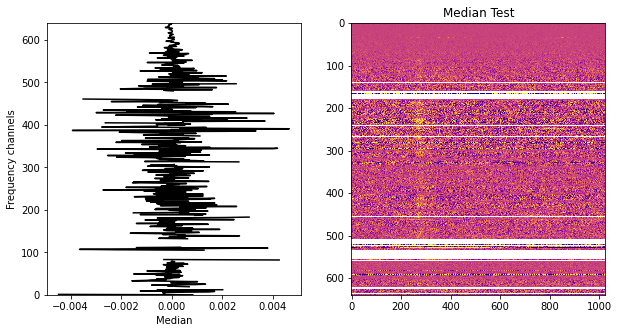

In [24]:
file_path  = '/srv/storage_11/galc/UBB/jtremblay/20230921/J1713+0747/folded_data/1614.84375/21:32:22_0016.ar'
result_array = clean_and_plot(file_path, threshold_dedisp = 0.05, threshold_disp = 500, on_pulse_start = 110, on_pulse_end = 150)
